Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

In [39]:
!pip install tensorflow
#!pip install google-colab

^C
ERROR: Operation cancelled by user
2.13->tensorflow) (2.0.3)


### Importing all the important libraries

In [40]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D

from skimage import io
import glob
import warnings
warnings.simplefilter('ignore')

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [41]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/Users/shivam.sachdeva/Downloads/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train")
data_dir_test = pathlib.Path('/Users/shivam.sachdeva/Downloads/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Test')

In [42]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [43]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [44]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [45]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [46]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

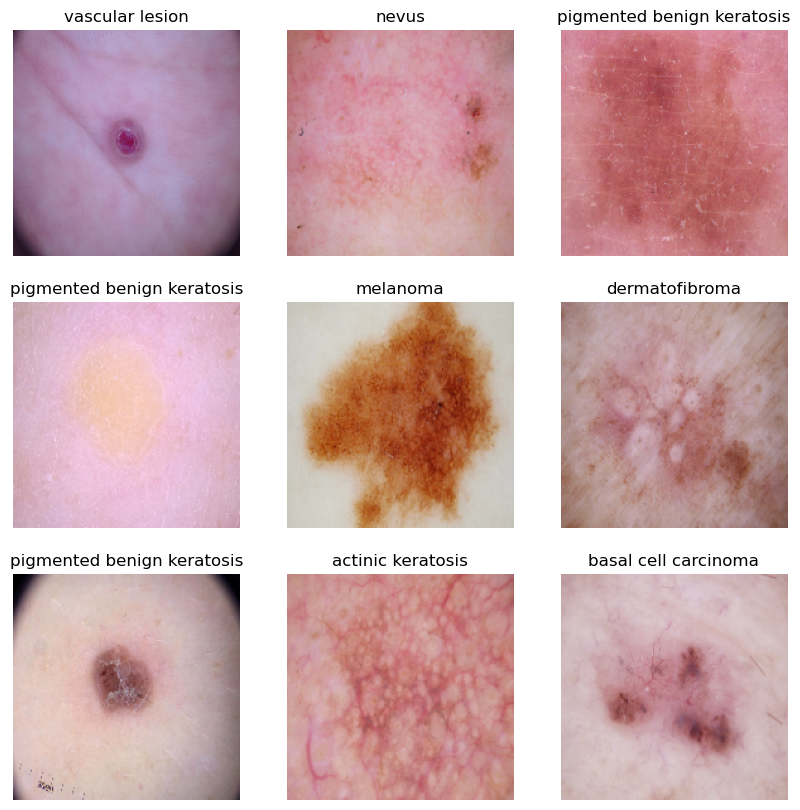

In [47]:
from PIL import Image
from matplotlib.colors import NoNorm


plt.figure(figsize=(10, 10))

for images, labels in train_ds.take(1):
  for i in range(len(class_names)):
    ax = plt.subplot(3, 3, i + 1)
    #bin_image = images[i][:, :, 0] > 100
    #plt.imshow(images[i].numpy().astype("uint8"),cmap='gray',norm=NoNorm())
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [48]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)



```
# This is formatted as code
```

### **Create the model: No. 1**
#### Created a CNN model, which can accurately detect 9 classes present in the dataset. Use ``layers.experimental.preprocessing.Rescaling`` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [49]:
normalization_layer = layers.Rescaling(1./255)

In [50]:
AfterNormalised_train = train_ds.map(lambda x, y: (normalization_layer(x), y))
AfterNormalised_val = val_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(AfterNormalised_train))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.046078194 0.75817025


In [51]:
# model architecture
from keras.layers import LeakyReLU

model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
input_shape=(img_height, img_width, 3)))
model.add(LeakyReLU(alpha=0.1))
model.add(Conv2D(32, (3, 3)))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(Conv2D(64, (3, 3)))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.5))
model.add(Dense(len(class_names)))
model.add(Activation('softmax'))

### **Compile the model**

Choose an appropirate optimiser and loss function for model training

In [52]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [53]:
# View the summary of all layers
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 180, 180, 32)      896       
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 180, 180, 32)      0         
                                                                 
 conv2d_13 (Conv2D)          (None, 178, 178, 32)      9248      
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 178, 178, 32)      0         
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 89, 89, 32)        0         
 g2D)                                                            
                                                                 
 dropout_9 (Dropout)         (None, 89, 89, 32)        0         
                                                      

### Train the model

In [54]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 109s 2s/step - loss: 202.6624 - accuracy: 0.1719 - val_loss: 251.9501 - val_accuracy: 0.0492
Epoch 2/20
56/56 [==============================] - 109s 2s/step - loss: 4.3456 - accuracy: 0.2729 - val_loss: 213.6165 - val_accuracy: 0.0515
Epoch 3/20
56/56 [==============================] - 127s 2s/step - loss: 2.7282 - accuracy: 0.3147 - val_loss: 203.8018 - val_accuracy: 0.0492
Epoch 4/20
56/56 [==============================] - 140s 2s/step - loss: 2.5057 - accuracy: 0.3516 - val_loss: 158.1014 - val_accuracy: 0.0515
Epoch 5/20
56/56 [==============================] - 105s 2s/step - loss: 2.2753 - accuracy: 0.3711 - val_loss: 139.3746 - val_accuracy: 0.0492
Epoch 6/20
56/56 [==============================] - 100s 2s/step - loss: 2.3389 - accuracy: 0.3828 - val_loss: 103.6675 - val_accuracy: 0.0515
Epoch 7/20
56/56 [==============================] - 98s 2s/step - loss: 2.0111 - accuracy: 0.4057 - val_loss: 92.2576 - val_accuracy: 0.0515

### Visualizing training results

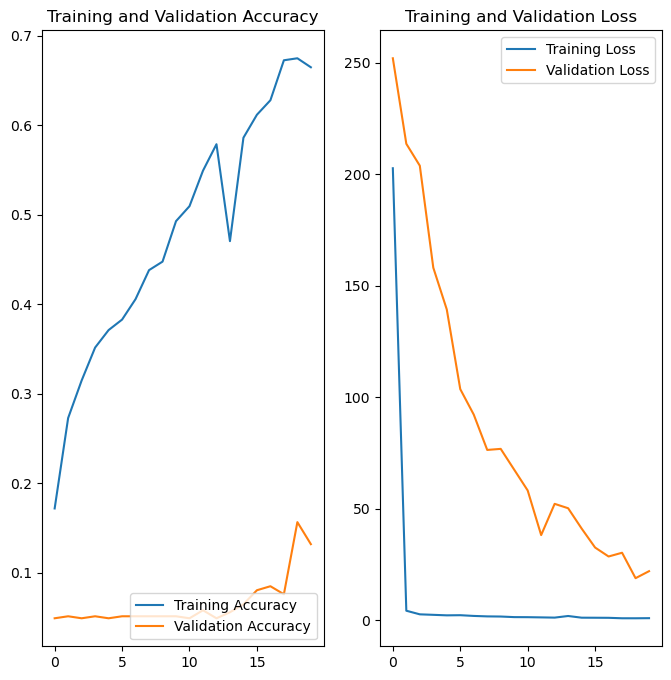

In [55]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### **Findings - Model 1**

A. The training and validation losses indicate the absence of concealed errors within the model.

B. The training and validation accuracies suggests that the model is exhibiting signs of overfitting.

C. Given the low validation accuracy, it is advisable to reattempt training with improved preprocessing techniques for more effective learning.


# <font color='GREEN'>Model 2 : Data augmentation Technique</font>
Chose an appropriate data augmentation strategy to resolve underfitting/overfitting

**Model Building & training on the augmented data:**

Create a CNN model, which can accurately detect 9 classes present in the dataset

Rescale images to normalize pixel values between (0,1).

Choose an appropriate optimiser and loss function for model training

Train the model for ~20 epochs

Write your findings after the model fit, see if the earlier issue is resolved or not?


### Todo:
### Create the model, compile and train the model


In [56]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here

n_channels = 3
DATASET_PATH = data_dir_train

In [57]:
from skimage.transform import rescale
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=10,
    width_shift_range=0,
    height_shift_range=0,
    vertical_flip=True,
    horizontal_flip=True,
    zoom_range=2.2)

def preprocess_img(img, mode):
    img = (img - img.min())/(img.max() - img.min())
    img = rescale(img, 0.25, multichannel=True, mode='constant')

    if mode == 'train':
        if np.random.randn() > 0:
            img = datagen.random_transform(img)
    return img

In [58]:
import numpy as np
import tensorflow as tf

# data generator with augmentation
class AugmentedDataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, mode='train', ablation=None, class_names= ['actinic keratosis','basal cell carcinoma','dermatofibroma','melanoma','nevus','pigmented benign keratosis','seborrheic keratosis','squamous cell carcinoma','vascular lesion'],
                 batch_size=3, dim=(img_height, img_width), n_channels=n_channels, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = {}
        self.list_IDs = []
        self.mode = mode

        for i, cls in enumerate(class_names):
            paths = glob.glob(os.path.join(DATASET_PATH, cls, '*'))
            brk_point = int(len(paths)*0.8)
            if self.mode == 'train':
                paths = paths[:brk_point]
            else:
                paths = paths[brk_point:]
            if ablation is not None:
                paths = paths[:ablation]
            self.list_IDs += paths
            self.labels.update({p:i for p in paths})


        self.n_channels = n_channels
        self.n_classes = len(class_names)
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)

        delete_rows = []

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            img = io.imread(ID)
            img = img/255
            if img.shape[0] > img_height and img.shape[1] > img_width:
                h, w, _ = img.shape
                img = img[int(h/2)-(img_height//2):int(h/2)+(img_height//2), int(w/2)-(img_width//2):int(w/2)+(img_width//2), : ]
            else:
                delete_rows.append(i)
                continue

            X[i,] = img

            # Store class
            y[i] = self.labels[ID]

        X = np.delete(X, delete_rows, axis=0)
        y = np.delete(y, delete_rows, axis=0)

        # data augmentation
        if self.mode == 'train':
            aug_x = np.stack([datagen.random_transform(img) for img in X])
            X = np.concatenate([X, aug_x])
            y = np.concatenate([y, y])
        return X, tf.keras.utils.to_categorical(y, num_classes=self.n_classes)

In [59]:
from sklearn.metrics import roc_auc_score
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import *

class roc_callback(Callback):

    def on_train_begin(self, logs={}):
        logs['val_auc'] = 0

    def on_epoch_end(self, epoch, logs={}):
        y_p = []
        y_v = []
        for i in range(len(validationDataGenerator)):
            x_val, y_val = validationDataGenerator[i]
            y_pred = self.model.predict(x_val)
            y_p.append(y_pred)
            y_v.append(y_val)
        y_p = np.concatenate(y_p)
        y_v = np.concatenate(y_v)
        roc_auc = roc_auc_score(y_v, y_p)
        print ('\nVal AUC for epoch{}: {}'.format(epoch, roc_auc))
        logs['val_auc'] = roc_auc

In [60]:
auc_logger = roc_callback()

In [61]:
# checkpoint
filepath = 'models/best_model.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_auc', verbose=1, save_best_only=True, mode='max')

In [62]:
# learning rate decay
class DecayLR(tf.keras.callbacks.Callback):
    def __init__(self, base_lr=0.001, decay_epoch=1):
        super(DecayLR, self).__init__()
        self.base_lr = base_lr
        self.decay_epoch = decay_epoch
        self.lr_history = []

    # set lr on_train_begin
    def on_train_begin(self, logs={}):
        tf.keras.backend.set_value(self.model.optimizer.lr, self.base_lr)

    # change learning rate at the end of epoch
    def on_epoch_end(self, epoch, logs={}):
        new_lr = self.base_lr * (0.5 ** (epoch // self.decay_epoch))
        self.lr_history.append(tf.keras.backend.get_value(self.model.optimizer.lr))
        tf.keras.backend.set_value(self.model.optimizer.lr, new_lr)

In [63]:
decay = DecayLR(base_lr=0.1)

In [64]:
training_generator = AugmentedDataGenerator('train')
validation_generator = AugmentedDataGenerator('val')

In [65]:
# model architecture
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                  input_shape=(img_height, img_width, 3)))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(len(class_names)))
model.add(Activation('softmax'))

### Compiling the model

In [74]:
model.compile(optimizer='SGD',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


### Training the model

In [75]:
## Your code goes here, note: train your model for 20 epochs
validation_generator = AugmentedDataGenerator('val')
epochs=20
history = model.fit(
  training_generator,
    validation_data=validation_generator,
    epochs=epochs,
  callbacks=[auc_logger, decay, checkpoint]
)

#   validation_data=validation_generator,
  

Epoch 1/20
595/595 [==============================] - ETA: 0s - loss: nan - accuracy: 0.0510

NameError: name 'validationDataGenerator' is not defined

### Visualizing the results

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### indings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

## <font color='red'> Model 2 Findings:
1. The train and validation accuracy are comparable, which means the model is not overfitting and is generalized.
2. The training and validation losses are decreasing which shows there are no hidden errors in the model
3. The validation accuracy had increased from model 1 , that is 0.2067 .



## <font color='green'> Model 3 With Balanced Data:
#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

#### **Todo:** Write your findings here:
#### - Which class has the least number of samples?
#### - Which classes dominate the data in terms proportionate number of samples?
    
Class distribution: Examine the current class distribution in the training dataset
- Least number of samples : **seborrheic keratosis with only 77 images in train set**
- Classes dominate the data in terms of the proportionate number of samples : **pigmented benign keratosis with 462 images**</font>

In [ ]:
D = {}
for i in class_names:
    disease_path = os.path.join(DATASET_PATH, i, '*')
    disease1 = glob.glob(disease_path)
    D.update({i : len(disease1)})


path_to_training_dataset = DATASET_PATH

In [ ]:
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i]+30, x[i], ha = 'center')
        plt.text(i, y[i], y[i], ha = 'center')


plt.bar(D.keys(), D.values())
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
addlabels(list(D.keys()),list(D.values()))
plt.show()

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [ ]:
#!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [ ]:
print(path_to_training_dataset)

In [ ]:
print(path_to_training_dataset)
import Augmentor
for i in class_names:
    path_to_training_dataset=os.path.join(DATASET_PATH, i)
    p = Augmentor.Pipeline(path_to_training_dataset)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [ ]:
image_count_train = len(list(path_to_training_dataset.glob('*/output/*.jpg')))
print(image_count_train)

### Lets see the distribution of augmented data after adding new images to the original training data.

In [ ]:
D = {}
for i in class_names:
    disease_path = os.path.join(DATASET_PATH, i, 'output','*')
    disease1 = glob.glob(disease_path)
    D.update({i : len(disease1)})


plt.bar(D.keys(), D.values())
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
addlabels(list(D.keys()),list(D.values()))
plt.show()

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

Create a CNN model, which can accurately detect 9 classes present in the dataset.

While building the model, rescale images to normalize pixel values between (0,1).

Choose an appropriate optimiser and loss function for model training

Train the model for ~30 epochs

Write your findings after the model fit. You must check if there is any evidence of model overfit or underfit.


In [ ]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create your model (make sure to include normalization)

In [ ]:
# model architecture
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                  input_shape=(img_height, img_width, 3)))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(len(class_names)))
model.add(Activation('softmax'))

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [ ]:
model.compile(optimizer='SGD',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
import numpy as np
import tensorflow as tf

# data generator with augmentation
class AugmentedDataGenerator_output(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, mode='train', ablation=None, class_names= ['actinic keratosis','basal cell carcinoma','dermatofibroma','melanoma','nevus','pigmented benign keratosis','seborrheic keratosis','squamous cell carcinoma','vascular lesion'],
                 batch_size=3, dim=(img_height, img_width), n_channels=n_channels, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = {}
        self.list_IDs = []
        self.mode = mode

        for i, cls in enumerate(class_names):
            paths = glob.glob(os.path.join(DATASET_PATH, cls,'output' ,'*'))
            brk_point = int(len(paths)*0.8)
            if self.mode == 'train':
                paths = paths[:brk_point]
            else:
                paths = paths[brk_point:]
            if ablation is not None:
                paths = paths[:ablation]
            self.list_IDs += paths
            self.labels.update({p:i for p in paths})


        self.n_channels = n_channels
        self.n_classes = len(class_names)
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)

        delete_rows = []

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            img = io.imread(ID)
            img = img/255
            if img.shape[0] > img_height and img.shape[1] > img_width:
                h, w, _ = img.shape
                img = img[int(h/2)-(img_height//2):int(h/2)+(img_height//2), int(w/2)-(img_width//2):int(w/2)+(img_width//2), : ]
            else:
                delete_rows.append(i)
                continue

            X[i,] = img

            # Store class
            y[i] = self.labels[ID]

        X = np.delete(X, delete_rows, axis=0)
        y = np.delete(y, delete_rows, axis=0)

        # data augmentation
        if self.mode == 'train':
            aug_x = np.stack([datagen.random_transform(img) for img in X])
            X = np.concatenate([X, aug_x])
            y = np.concatenate([y, y])
        return X, tf.keras.utils.to_categorical(y, num_classes=self.n_classes)

In [ ]:
training_generator = AugmentedDataGenerator_output('train', ablation=100)
validation_generator = AugmentedDataGenerator_output('val', ablation=100)

#### **Todo:**  Train your model

In [ ]:
epochs=30
history = model.fit(
  training_generator,
  validation_data=validation_generator,
  epochs=epochs,
  callbacks=[auc_logger, decay, checkpoint]
)

#### **Todo:**  Visualize the model results

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



## Model 3 Findings:
1. The training and validation losses decreased which shows that there are no hidden errors in the model
2. The training accuracy is increased with the number of epochs
3. The validation accuracy is 0.111